In [1]:
%%time

#titanicコンペ
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
import warnings
# filter warnings
warnings.filterwarnings('ignore')

#データファイルの読み込み
train = pd.read_csv("../../input/titanic/train.csv")
test = pd.read_csv("../../input/titanic/test.csv")
gender_submission = pd.read_csv("../../input/titanic/gender_submission.csv")

CPU times: user 124 ms, sys: 32 ms, total: 156 ms
Wall time: 154 ms


In [2]:
%%time
#特徴量エンジニアリング-start
#kaggleではtrainとtestを結合
data = pd.concat([train,test])
print(data.shape)
#data.head()

#Sex:性別は文字列なので数値に変換する:inplaceオプションで元データも書き換え
data['Sex'].replace(['male','female'],[0, 1], inplace=True)

#Embarkedには欠損値があるので大多数を占める「S」でうめる
data['Embarked'].fillna(('S'), inplace=True)
##Embarkedは文字列なので数値に変換
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

#運賃も関係あるかも
#一つ欠損値が存在するため平均値で埋める
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
data['Sex'].value_counts()
data['Embarked'].value_counts()
#data['Fare'].value_counts()



(1309, 12)
CPU times: user 11.4 ms, sys: 208 µs, total: 11.6 ms
Wall time: 9.9 ms


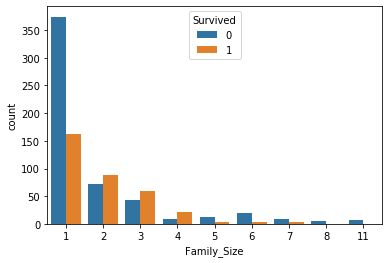

In [3]:
#家族の人数が多いと生存率がさがるのでは？という仮設を立てる
#「家族の人数」を示す特徴量を作る
#データの中に「Parch：兄弟姉妹/配偶者の数」、「SibSp：親子の数」があるので
#これを足して特徴量を生成
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1
train['Family_Size'] = data['Family_Size'][:len(train)]
test['Family_Size'] = data['Family_Size'][len(train):]

import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Family_Size', data = train, hue = 'Survived')

#一人だけの乗客と5人以上の家族連れは生存率が低い
#「一人だけ」という特徴量も作る

data['IsAlone'] = 0
data.loc[data['Family_Size'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

#train.head()

In [4]:
%%time
#運賃も欠損値が存在するため平均値で埋める
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

#Age：年齢も加味してみる
age_avg = data['Age'].mean()
age_std = data['Age'].std()
#平均年齢に標準へ差の幅で欠損値を埋める
data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
#train.head()
#data.head()

#とりあえずここまでで特徴量を考慮しなかった列は削除
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis = 1, inplace = True)

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 2.3 ms


In [5]:
#特徴量エンジニアリング後のデータについてtrainとtestにわける
train = data[:len(train)]
test = data[len(train):]

print(train.shape)
train.head()

(891, 8)


,Age,Embarked,Fare,Pclass,Sex,Survived,Family_Size,IsAlone
0,22.0,0,7.2500,3,0,0.0,2,0
1,38.0,1,71.2833,1,1,1.0,2,0
2,26.0,0,7.9250,3,1,1.0,1,1
3,35.0,0,53.1000,1,1,1.0,2,0
4,35.0,0,8.0500,3,0,0.0,1,1


In [6]:
#x_train：学習データ、正解ラベル(Survived)の列は削除
#y_train：学習データ、正解ラベル(Survived)のみとする
#x_test：検証データ、正解ラベル(Survived)の列は削除

y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)
y_test = test['Survived']

#確認
print("x_train:" + str(X_train.shape))
print("y_train:" + str(y_train.shape))
print("x_test:" + str(X_test.shape))
print("y_test:" + str(y_test.shape))
X_train.head()

x_train:(891, 7)
y_train:(891,)
x_test:(418, 7)
y_test:(418,)


,Age,Embarked,Fare,Pclass,Sex,Family_Size,IsAlone
0,22.0,0,7.2500,3,0,2,0
1,38.0,1,71.2833,1,1,2,0
2,26.0,0,7.9250,3,1,1,1
3,35.0,0,53.1000,1,1,2,0
4,35.0,0,8.0500,3,0,1,1


In [7]:
#UMAP
import umap
import seaborn as sns

(891, 2)


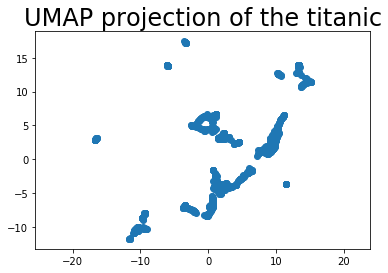

In [9]:
#parameter

n_neighbors = 15#default:15 2～
min_dist = 0.1#データ間の最小距離 default:0.1 0～0.99? 大:トポロジ構造 小:クラスタリング
n_components = 2#UMAPでクラスタリングしたときの次元数
metric = 'euclidean'#データ間の距離計算式(カスタム可能)

#基本的な使い方
fit = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    metric=metric
)

embedding = fit.fit_transform(X_train)
print(embedding.shape)

plt.scatter(embedding[:, 0], embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the titanic', fontsize=24);

In [12]:
#パラメータを弄って確認

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(X_train);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        #ax.scatter(u[:,0], range(len(u)), c=X_train)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        #ax.scatter(u[:,0], u[:,1], c=X_train)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(u[:,0], u[:,1], u[:,2], c=X_train, s=100)
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

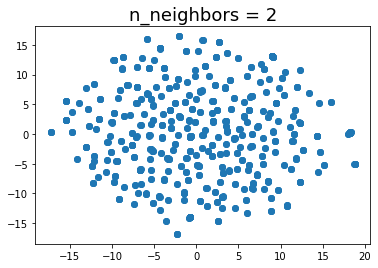

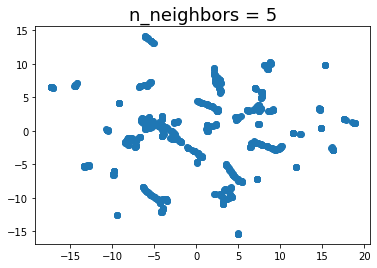

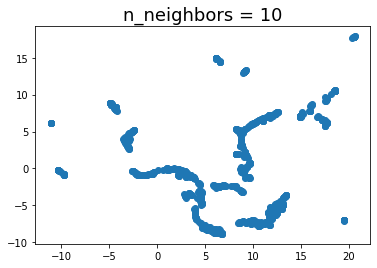

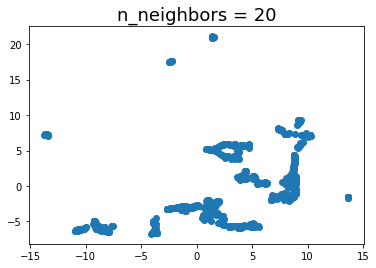

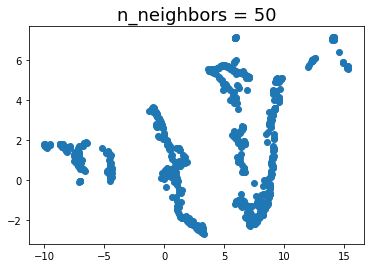

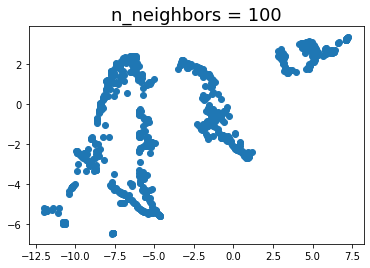

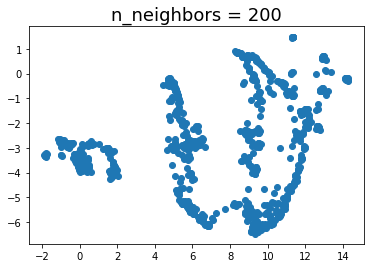

In [13]:
#n_neighborsの確認
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

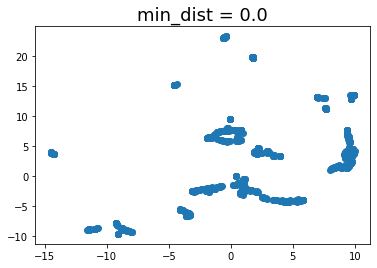

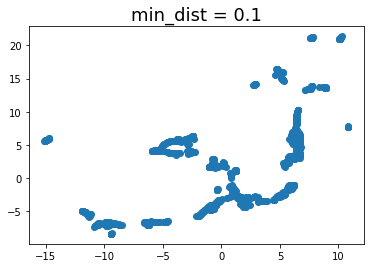

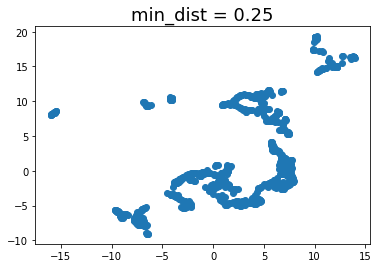

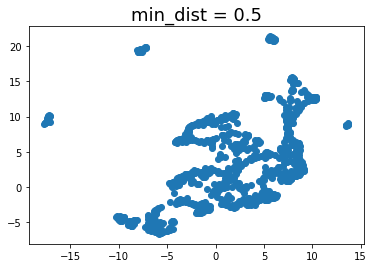

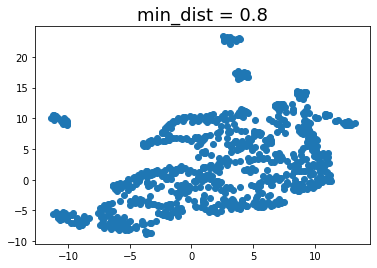

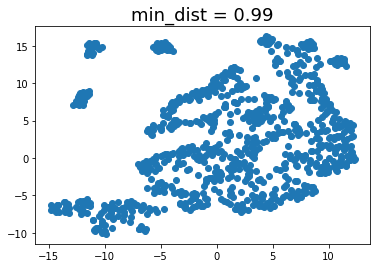

In [14]:
#min_distの確認
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

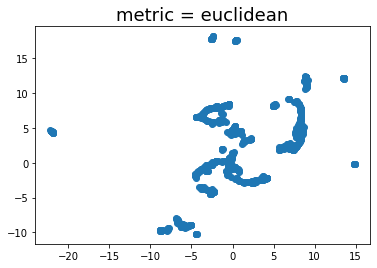

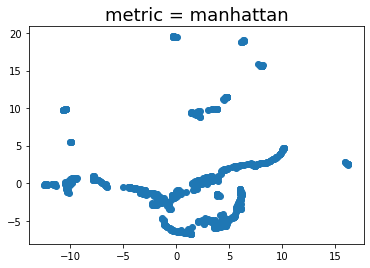

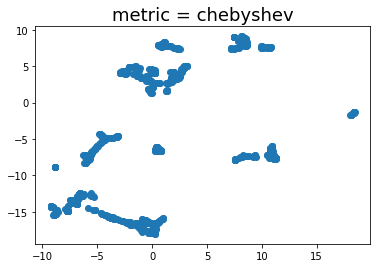

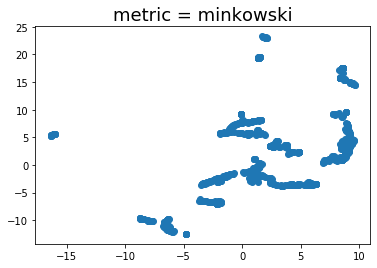

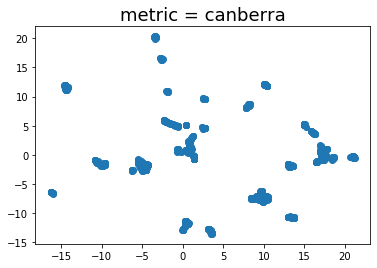

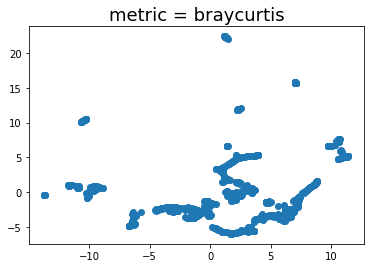

In [16]:
#metricの確認1

for m in ("euclidean", "manhattan","chebyshev","minkowski","canberra","braycurtis"):
    draw_umap(n_components=2, metric=m, title='metric = {}'.format(m))

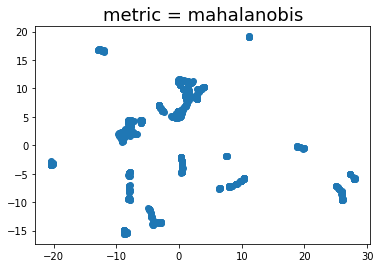

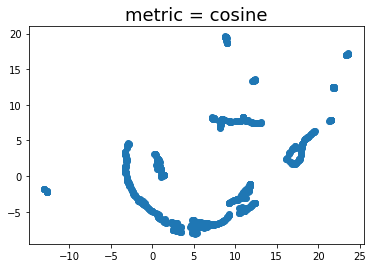

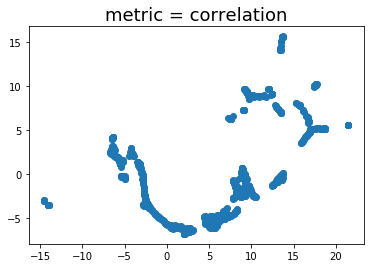

In [20]:
#metricの確認2

#そのままじゃ動かないリスト(重みの設定などが必要)
#"haversine",
#"wminkowski",
#"seuclidean",
#

for m in ("mahalanobis","cosine","correlation"):
    draw_umap(n_components=2, metric=m, title='metric = {}'.format(m))